# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

1.One-hot vectors treat each word as an independent element, failing to represent semantic relationships between words. Furthermore, they generate extremely high-dimensional and sparse vectors where most elements are zeros, thus unable to reflect word similarity.

2.This means that the meaning of a word can be understood by observing which words it frequently appears alongside. If two words typically appear in similar contexts, they often share similar semantic meanings. Therefore, models can learn semantic connections between words by statistically analyzing co-occurrence relationships.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [1]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [3]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/luckgucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luckgucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [5]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(
    subset="train",
    remove=("headers", "footers", "quotes")
)

documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [10]:
import nltk
nltk.download("punkt_tab")
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/luckgucci/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /Users/luckgucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luckgucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    tokens = word_tokenize(text.lower())

    tokens = [
        token for token in tokens
        if token.isalpha() and token not in stop_words
    ]

    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.

1.Stopwords (such as the, is, and, etc.) are typically words that are extremely common in language but carry little semantic information. If retained, these words appear frequently and interfere with the model's ability to learn meaningful word relationships. Removing stopwords reduces noise, making it easier for word embeddings to capture important semantic information.

2.In certain tasks, stopwords may contain important information. For example, in sentiment analysis or language comprehension tasks, words like “not” or “never” can alter the meaning of a sentence. Removing these words may cause the model to misinterpret the text's meaning.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [12]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v =w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1
)


print("Vocabulary size:", len(w2v.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [13]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

# YOUR CODE HERE
print(w2v.wv["computer"][:10])


[ 0.03196514  0.28954    -0.4626792  -0.04774381 -0.3268739  -0.532187
 -0.35558632  0.27494547  0.29134467 -0.06375363]


### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [14]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "computer"
print(f"Most similar words to '{target}':")

# YOUR CODE HERE - iterate through the results and print each word and score
results = w2v.wv.most_similar(target, topn=10)

for word, score in results:
    print(word, score)


Most similar words to 'computer':
transmits 0.6974708437919617
networks 0.6941441893577576
engineering 0.6859982013702393
shopper 0.6841151118278503
mainframe 0.6793056130409241
dsp 0.6788175702095032
isdn 0.6770941019058228
silicon 0.6724515557289124
architecture 0.671259880065918
engineer 0.6706455945968628


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.

1.The neighbors reflect both topic similarity and functional similarity. Many words such as "networks", "engineering", "mainframe", and "architecture" are related to the field of computing, showing topic similarity. At the same time, words like "transmits" and "engineer" relate to functions or activities associated with computers, demonstrating functional similarity.

2.One surprising neighbor is "shopper". This word may appear because computers are frequently mentioned in contexts related to online shopping, e-commerce systems, or consumer technology discussions. As a result, the model learns that "shopper" often appears in documents discussing computers and technology.

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [15]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

# YOUR CODE HERE
query_positive = ["king", "woman"]
query_negative = ["man"]

# (Optional) quick check: make sure the words exist in vocab
for w in query_positive + query_negative:
    if w not in w2v.wv.key_to_index:
        print(f"⚠️ '{w}' not in vocabulary!")

results = w2v.wv.most_similar(positive=query_positive, negative=query_negative, topn=5)

print("Analogy: king - man + woman ≈ ?")
for word, score in results:
    print(word, score)


Analogy: king - man + woman ≈ ?
kicked 0.7631288170814514
deposition 0.7616901993751526
stone 0.7575198411941528
omar 0.7522233128547668
valery 0.7483933568000793


### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [ ]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

In [17]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm

result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"]
similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")
from numpy.linalg import norm
import numpy as np


Cosine similarity to 'queen': 0.5968


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.

1.Analogy results may fail because embeddings capture statistical patterns from training data rather than perfect semantic rules. If the corpus is small, biased, or lacks diversity, the embedding may not learn consistent vector relationships. Furthermore, polysemy and noise in language can interfere with analogy performance.

2.Analogy evaluation is considered an intrinsic evaluation, which focuses on geometric relationships in embedding space rather than real application performance. Downstream NLP tasks often depend on additional contextual or task-specific information, so analogy accuracy does not always reflect real-world usefulness.


---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

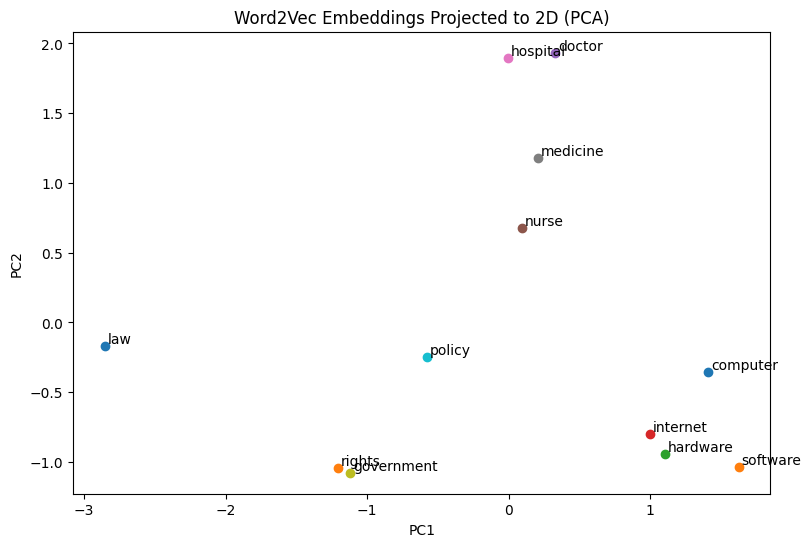

In [19]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = [w2v.wv[w] for w in words]

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

1.
Several groups of semantically related words appear close together in the visualization.
The words “doctor,” “hospital,” “nurse,” and “medicine” are tightly clustered, suggesting strong similarity in the healthcare domain.
Similarly, “software,” “hardware,” “internet,” and “computer” are positioned relatively close to each other, indicating a technology-related grouping.
In addition, “government,” “rights,” and “policy” appear near each other, suggesting a political or legal theme.

2.
Yes, the plot shows partial clustering by topic. Healthcare-related terms form a clear cluster near the top of the visualization, while technology-related words cluster toward the right side. Political and legal terms appear grouped toward the lower-left region.
However, the clusters are not perfectly separated. This may be explained by several factors. First, PCA reduces high-dimensional embeddings to only two dimensions, which can distort distances and reduce separation between groups. Second, Word2Vec captures contextual similarity, meaning some words may appear in multiple contexts. Finally, the training corpus (20 Newsgroups dataset) contains mixed topics, which can blur boundaries between semantic categories.

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [20]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4
from gensim.models import FastText

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

print("FastText vocabulary size:", len(ft.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [21]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)

ft_results = ft.wv.most_similar(query, topn=5)

for word, score in ft_results:
    print(word, score)


# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)

    w2v_results = w2v.wv.most_similar(query, topn=5)

    for word, score in w2v_results:
        print(word, score)

else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
computes 0.9750317931175232
comics 0.9582425355911255
compute 0.9556677937507629
compact 0.9516131281852722
competitors 0.9452276825904846

Word2Vec neighbors for: computers
multimedia 0.8662692308425903
platforms 0.8609904050827026
accessible 0.8594390153884888
sgcs 0.8575652837753296
developers 0.8502619862556458


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

Comparison: Word2Vec vs FastText for "computers"

The results show clear differences between FastText and Word2Vec when retrieving neighbors for the word "computers".

FastText returns neighbors such as *computes*, *compute*, and *compact*. Many of these words share similar character patterns or morphological roots with "computers". This behavior occurs because FastText represents words as collections of character n-grams, allowing it to capture morphological relationships and handle variations of the same root word.

In contrast, Word2Vec returns neighbors such as *multimedia*, *platforms*, and *developers*. These words are not morphologically related to "computers", but they are semantically related and often appear in similar contexts. Word2Vec learns embeddings at the whole-word level and therefore relies primarily on contextual co-occurrence rather than subword structure.

Overall, FastText demonstrates stronger performance in capturing morphological similarity and handling word variants, while Word2Vec tends to emphasize semantic similarity based on usage context.


---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [23]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):

    # YOUR CODE HERE
    
    # Check if word exists in vocabulary
    if word not in model.wv:
        return None
    
    # Otherwise return neighbors
    return model.wv.most_similar(word, topn=topn)

    # Check if word is in model.wv, if not return None
    # Otherwise return model.wv.most_similar(word, topn=topn)
    pass

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  nationwide      0.897
  airport         0.894
  pacific         0.893
  quincy          0.887
  alaska          0.885
  theatre         0.881
  denver          0.881
  labour          0.878

Query: space
  nasa            0.726
  shuttle         0.722
  redesign        0.683
  jenks           0.674
  exploration     0.671
  advertising     0.661
  station         0.660
  goddard         0.647

Query: religion
  religions       0.852
  intellectual    0.836
  christian       0.835
  mormons         0.831
  doctrines       0.829
  homosexuality   0.829
  racist          0.828
  religious       0.824

Query: graphics
  cad             0.843
  radiosity       0.819
  animation       0.819
  gems            0.818
  workshop        0.810
  editing         0.802
  multimedia      0.801
  silicon         0.799


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?

Chosen query: "hotel"
1. 
Some neighbors are helpful because they relate to travel contexts, such as airport and theatre. These terms commonly co-occur with hotels and may support discovery. However, some results like labour are less relevant to user search intent, showing that embeddings capture contextual similarity rather than exact meaning.

2.
Embeddings alone may not capture user intent and can return loosely related results. The model is also trained on discussion-based data, which may introduce bias and reduce relevance for real search tasks. Additionally, out-of-vocabulary words (e.g., "motel") may lead to missing results.

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

GloVe is a count-based embedding model that learns word meaning from global co-occurrence statistics. Unlike Word2Vec, which predicts local context words, GloVe captures relationships using aggregated corpus-level information. This often helps preserve linear semantic relationships but requires more computation and storage.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?

1.
One-hot vectors are highly sparse, with only one position set to 1 for each word and all others set to 0. Consequently, they cannot reflect semantic similarity between different words. Word vectors map words to a low-dimensional continuous vector space, placing semantically similar words closer together in this space. In this experiment, for instance, “computer” is surrounded by words like ‘networks’ and “engineering,” demonstrating the model's ability to capture technology-related semantic relationships. This continuous representation not only reduces sparsity but also enables measuring semantic similarity between words via cosine similarity. Consequently, embeddings can more effectively support downstream tasks.

2.
Word vectors are widely used in search engines and recommendation systems. For example, in the semantic search task of this experiment, when “hotel” was entered, the model returned related words such as “airport,” “theatre,” and “denver.” This demonstrates that the model can identify semantically related content, not just exact keyword matches. In real-world search systems, this helps users find more relevant results even when query terms don't perfectly match document vocabulary. Additionally, word vectors are widely applied in tasks like chatbots and text classification.

3.
When data contains spelling variations, plural forms, or out-of-vocabulary (OOV) words, FastText is more suitable. In this experiment, when querying the term “computers,” FastText can identify words like ‘compute’ and “computes,” whereas Word2Vec requires words to be present in the vocabulary to process them. FastText employs subword (character n-gram) modeling, enabling the model to understand morphological variations. Consequently, FastText typically demonstrates greater stability when processing user-generated text, social media data, or specialized terminology.

4.
Word vectors are highly dependent on training corpora. If training data is biased or has limited coverage, the model may learn inaccurate or biased semantic relationships. For example, in this experiment, “king – man + woman” did not yield “queen,” indicating that small-scale or domain-limited data can affect semantic structure. Furthermore, embeddings may map polysemous words from different contexts to the same vector, reducing semantic discrimination capabilities. Therefore, industrial applications require integration with larger corpora or contextual models to mitigate these issues.

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [24]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(corpus, min_count=5, threshold=10)
bigram = Phraser(phrases)

corpus_bigram = [bigram[s] for s in corpus]


In [25]:
from gensim.models import Word2Vec

w2v_bigram = Word2Vec(
    sentences=corpus_bigram,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)


In [26]:
print("Original:")
print(w2v.wv.most_similar("computer"))

print("\nBigram model:")
print(w2v_bigram.wv.most_similar("computer"))


Original:
[('transmits', 0.6974708437919617), ('networks', 0.6941441893577576), ('engineering', 0.6859982013702393), ('shopper', 0.6841151118278503), ('mainframe', 0.6793056130409241), ('dsp', 0.6788175702095032), ('isdn', 0.6770941019058228), ('silicon', 0.6724515557289124), ('architecture', 0.671259880065918), ('engineer', 0.6706455945968628)]

Bigram model:
[('memory', 0.9895797371864319), ('mac', 0.9890236854553223), ('chip', 0.9884999394416809), ('card', 0.988321840763092), ('ram', 0.9876919388771057), ('board', 0.9868221282958984), ('pc', 0.9850823879241943), ('monitor', 0.9841300249099731), ('access', 0.98410964012146), ('scsi', 0.9816798567771912)]


After adding bigrams, the neighbors for "computer" shifted from general technical topics (e.g., networks, engineering) to more specific hardware-related terms (e.g., memory, chip, ram, pc). This indicates that phrase modeling helps the embedding capture more precise domain semantics.